<p align="center">
<b>DSC 212 Assignment</b><br>
Avigail Agrawal<br>
IMS24056<br><br>
<i>Please click <b>RUN ALL</b></i><br><br>
Thank you
</p>


## Discussion on Centrality Trends
(only meant for the karate club graph)

**Nodes 33 and 0** consistently had high **degree centrality**, and remained well connected across splits.

**Node 33** also started with moderate **betweenness centrality** which only increased with iterations, with it practically being the anchor for its final sub-community. **Node 0** showed a similar trend.

**Nodes 33 and 0** were *anchors* and hence showed high **closeness centrality** across all splits, with **node 32** catching up progressively with iterations.

**Nodes 16 and 15** maintained high **clustering centrality** the longest before falling off like all other nodes.

**Local degree centrality** seems to increase with splits for most nodes, indicating the highly *social* or connected nodes keep their communities together.

**Betweenness centrality** also seems to increase but only above a certain threshold, below which it usually falls off to zero, suggesting *failed bridges* or nodes that failed to keep their community together because they weren't necessary enough for reaching other nodes or *information flow*.

**Closeness centrality** appears to be highly similar to degree centrality, and shows a similar trend, particularly at higher iterations—suggesting people with more immediate friends tend to have more reachable indirect friends in general.

**Clustering centrality** consistently fell off, showing that smaller communities often relied on anchors rather than a close-knit bond between all the nodes.

**Overall**, these trends show that influential nodes transform into local leaders, keeping their communities connected, whereas peripheral or sparsely connected nodes lose importance as modularity increases.


### Note: External means were used for the **plotting** part of the code, as I could not develop enough proficiency in using matplotlib in the given timeframe. Kindly excuse this cutting of corners.

### P.S.: The code is commented for ease of understanding.

In [ ]:
'''SPLITTING CODE'''

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

iteration = 1
community_id = 0

metric_history = {
    'degree': {},
    'betweenness': {},
    'closeness': {},
    'clustering': {}
}


#method to compute centrality metrics and storing them in a dictionary
def compute_metrics_for_subgraph(G, iteration):
    deg = nx.degree_centrality(G)
    metric_history['degree'].setdefault(iteration, {}).update(deg)
    btw = nx.betweenness_centrality(G)
    metric_history['betweenness'].setdefault(iteration, {}).update(btw)
    clo = nx.closeness_centrality(G)
    metric_history['closeness'].setdefault(iteration, {}).update(clo)
    clust = nx.clustering(G)
    metric_history['clustering'].setdefault(iteration, {}).update(clust)

#method for color assignment
def assign_final_color(G, global_color_map):
    global community_id
    rng = np.random.default_rng(community_id)
    color = rng.random(3,)
    for node in G.nodes():
        global_color_map[node] = color
    community_id += 1


def recursive_split(G, pos, iteration, cmap=None, groups_by_iter=None):
#recursively splitting the grpah by sign of leading eigenvector
    global_color_map = cmap if cmap else {}
    if groups_by_iter is None:
        groups_by_iter = {}

#stopping if recursion gets too deep
    MAX_DEPTH = 15
    if iteration > MAX_DEPTH:
        assign_final_color(G, global_color_map)
        groups_by_iter.setdefault(iteration, []).append((G.copy(), global_color_map.copy()))
# record metrics for this final subgraph at this iteration
        compute_metrics_for_subgraph(G, iteration)
        return groups_by_iter, global_color_map
    
#if graph is too small to split
    if G.number_of_edges() == 0 or G.number_of_nodes() <= 2:
        assign_final_color(G, global_color_map)
        groups_by_iter.setdefault(iteration, []).append((G.copy(), global_color_map.copy()))
        compute_metrics_for_subgraph(G, iteration)
        return groups_by_iter, global_color_map

#algebra for modularity as given in assignment
    A = nx.to_numpy_array(G)
    k = np.sum(A, axis=1)
    m = G.number_of_edges()
    B = A - np.outer(k, k) / (2*m)

#leading eigenvector is the minimiser of the relaxation Q = 1/4m sT B s
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
    lambda1, u1 = eigvals[0], eigvecs[:, 0]
    print(f"Iteration {iteration}: λ₁ = {lambda1:.8f}, nodes = {G.number_of_nodes()}")

#if highest eigenvalue is negative, then no split exists that increases modularity
    if np.isnan(lambda1) or lambda1 <= 1e-8:
        assign_final_color(G, global_color_map)
        groups_by_iter.setdefault(iteration, []).append((G.copy(), global_color_map.copy()))
        compute_metrics_for_subgraph(G, iteration)
        return groups_by_iter, global_color_map

#bipartition by sign of leading eigenvector
    s = np.sign(u1)
    nodes = list(G.nodes())
    group1 = [nodes[i] for i in range(len(s)) if s[i] >= 0]
    group2 = [nodes[i] for i in range(len(s)) if s[i] < 0]

#checking for positive eigenvalue but zero nodes on one side of bipartition
    if len(group1) == 0 or len(group2) == 0:
        assign_final_color(G, global_color_map)
        groups_by_iter.setdefault(iteration, []).append((G.copy(), global_color_map.copy()))
        compute_metrics_for_subgraph(G, iteration)
        return groups_by_iter, global_color_map

#assigning random colors to the new subgraphs
    rng = np.random.default_rng(iteration * 123 + len(group1))
    color1, color2 = rng.random(3,), rng.random(3,)
    for node in group1:
        global_color_map[node] = color1
    for node in group2:
        global_color_map[node] = color2

#creating subgraphs and recording a snapshot for plotting
    G1, G2 = G.subgraph(group1).copy(), G.subgraph(group2).copy()
    groups_by_iter.setdefault(iteration, []).append((G1, global_color_map.copy()))
    groups_by_iter.setdefault(iteration, []).append((G2, global_color_map.copy()))
    compute_metrics_for_subgraph(G1, iteration)
    compute_metrics_for_subgraph(G2, iteration)

#recursing over subgraphs
    groups_by_iter, global_color_map = recursive_split(G1, pos, iteration + 1, global_color_map, groups_by_iter)
    groups_by_iter, global_color_map = recursive_split(G2, pos, iteration + 1, global_color_map, groups_by_iter)

    return groups_by_iter, global_color_map


def plot_iterations(groups_by_iter, pos):
    for it, graph_tuples in sorted(groups_by_iter.items()):
        n = len(graph_tuples)
        cols = min(n, 3)
        rows = int(np.ceil(n / cols))
        plt.figure(figsize=(5*cols, 4*rows))
        for i, (g, color_snapshot) in enumerate(graph_tuples, 1):
            plt.subplot(rows, cols, i)
            nx.draw(g, pos, with_labels=True,
                    node_color=[color_snapshot.get(node, 'lightgrey') for node in g.nodes()],
                    node_size=500, edgecolors='black')
            plt.title(f"Iteration {it}, Subgraph {i}\n(n={g.number_of_nodes()}, m={g.number_of_edges()})")
        plt.suptitle(f"Communities found at Iteration {it}", fontsize=16)
        plt.tight_layout()
        plt.show()

def plot_metric_evolution(metric_history, top_k=5):
#plotting centrality metric changes across iterations for top-k nodes per metric
    for metric_name, metric_dict in metric_history.items():
        if len(metric_dict) == 0:
#nothing recorded for this metric
            continue

        sorted_iters = sorted(metric_dict.keys())

        all_nodes = set().union(*[metric_dict[it].keys() for it in sorted_iters])

#computing average centrality over iterations for ranking
        avg_values = {}
        for node in all_nodes:
            vals = [metric_dict[it].get(node, np.nan) for it in sorted_iters]
            finite_vals = [v for v in vals if not np.isnan(v)]
            avg_values[node] = np.mean(finite_vals) if finite_vals else 0

#picking top-k most central nodes overall
        top_nodes = sorted(avg_values, key=avg_values.get, reverse=True)[:top_k]

        plt.figure(figsize=(10,6))
        for node in sorted(all_nodes):
            y = [metric_dict[it].get(node, np.nan) for it in sorted_iters]
#drawing non-top nodes lightly
            if node not in top_nodes:
                plt.plot(sorted_iters, y, color='grey', alpha=0.3)
            else:
                plt.plot(sorted_iters, y, marker='o', alpha=0.9, label=f'Node {node}')
#adding node number label at the last valid point
                last_valid_idx = np.where(~np.isnan(y))[0]
                if len(last_valid_idx) > 0:
                    x_label = sorted_iters[last_valid_idx[-1]]
                    y_label = y[last_valid_idx[-1]]
                    plt.text(x_label + 0.1, y_label, str(node),
                             fontsize=9, weight='bold', ha='left', va='center')

        plt.title(f"Evolution of {metric_name.capitalize()} Centrality (Top {top_k} nodes)")
        plt.xlabel("Iteration")
        plt.ylabel(metric_name.capitalize())
        plt.xticks(sorted_iters)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.tight_layout()
        plt.show()



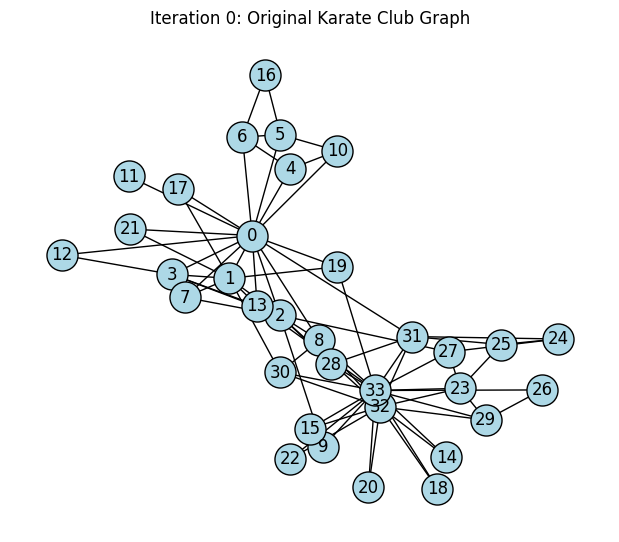

Iteration 1: λ₁ = 17.10834919, nodes = 34
Iteration 2: λ₁ = 7.87518988, nodes = 18
Iteration 3: λ₁ = 3.80372237, nodes = 12
Iteration 4: λ₁ = 1.88581015, nodes = 10
Iteration 5: λ₁ = 0.98193121, nodes = 8
Iteration 6: λ₁ = -0.00000000, nodes = 3
Iteration 6: λ₁ = 0.00000000, nodes = 5
Iteration 3: λ₁ = 3.53450404, nodes = 6
Iteration 4: λ₁ = 0.00000000, nodes = 3
Iteration 4: λ₁ = -0.00000000, nodes = 3
Iteration 2: λ₁ = 10.02563267, nodes = 16
Iteration 3: λ₁ = 1.98360852, nodes = 8
Iteration 4: λ₁ = 0.60880646, nodes = 6
Iteration 5: λ₁ = -0.00000000, nodes = 4
Iteration 3: λ₁ = 3.58981372, nodes = 8
Iteration 4: λ₁ = 1.42742945, nodes = 5
Iteration 5: λ₁ = -0.00000000, nodes = 3
Iteration 4: λ₁ = -2.40913023, nodes = 3


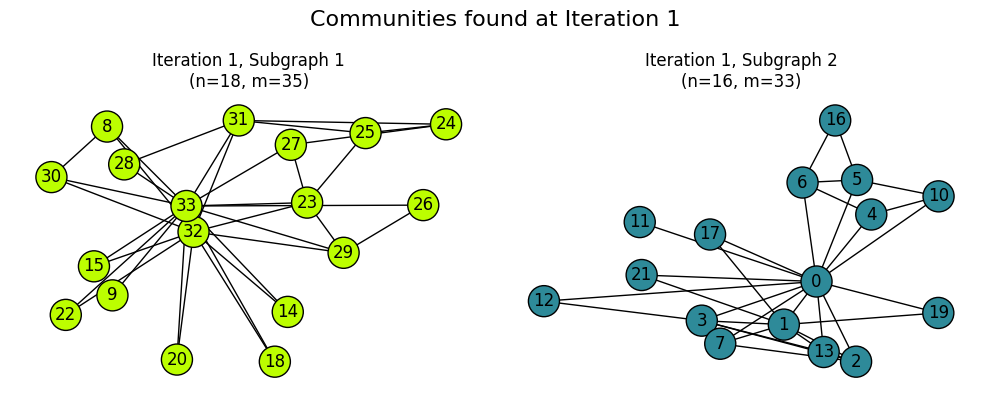

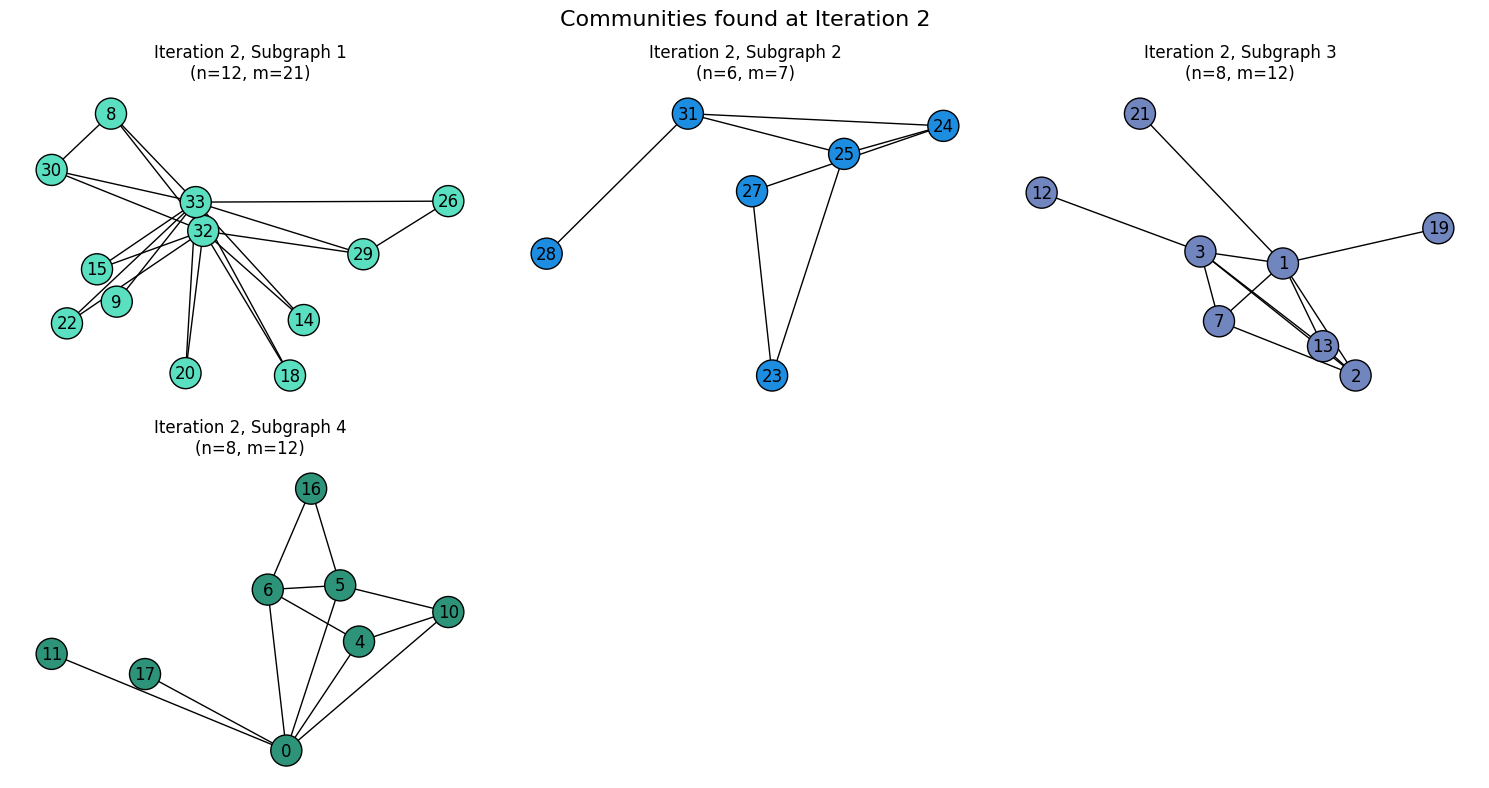

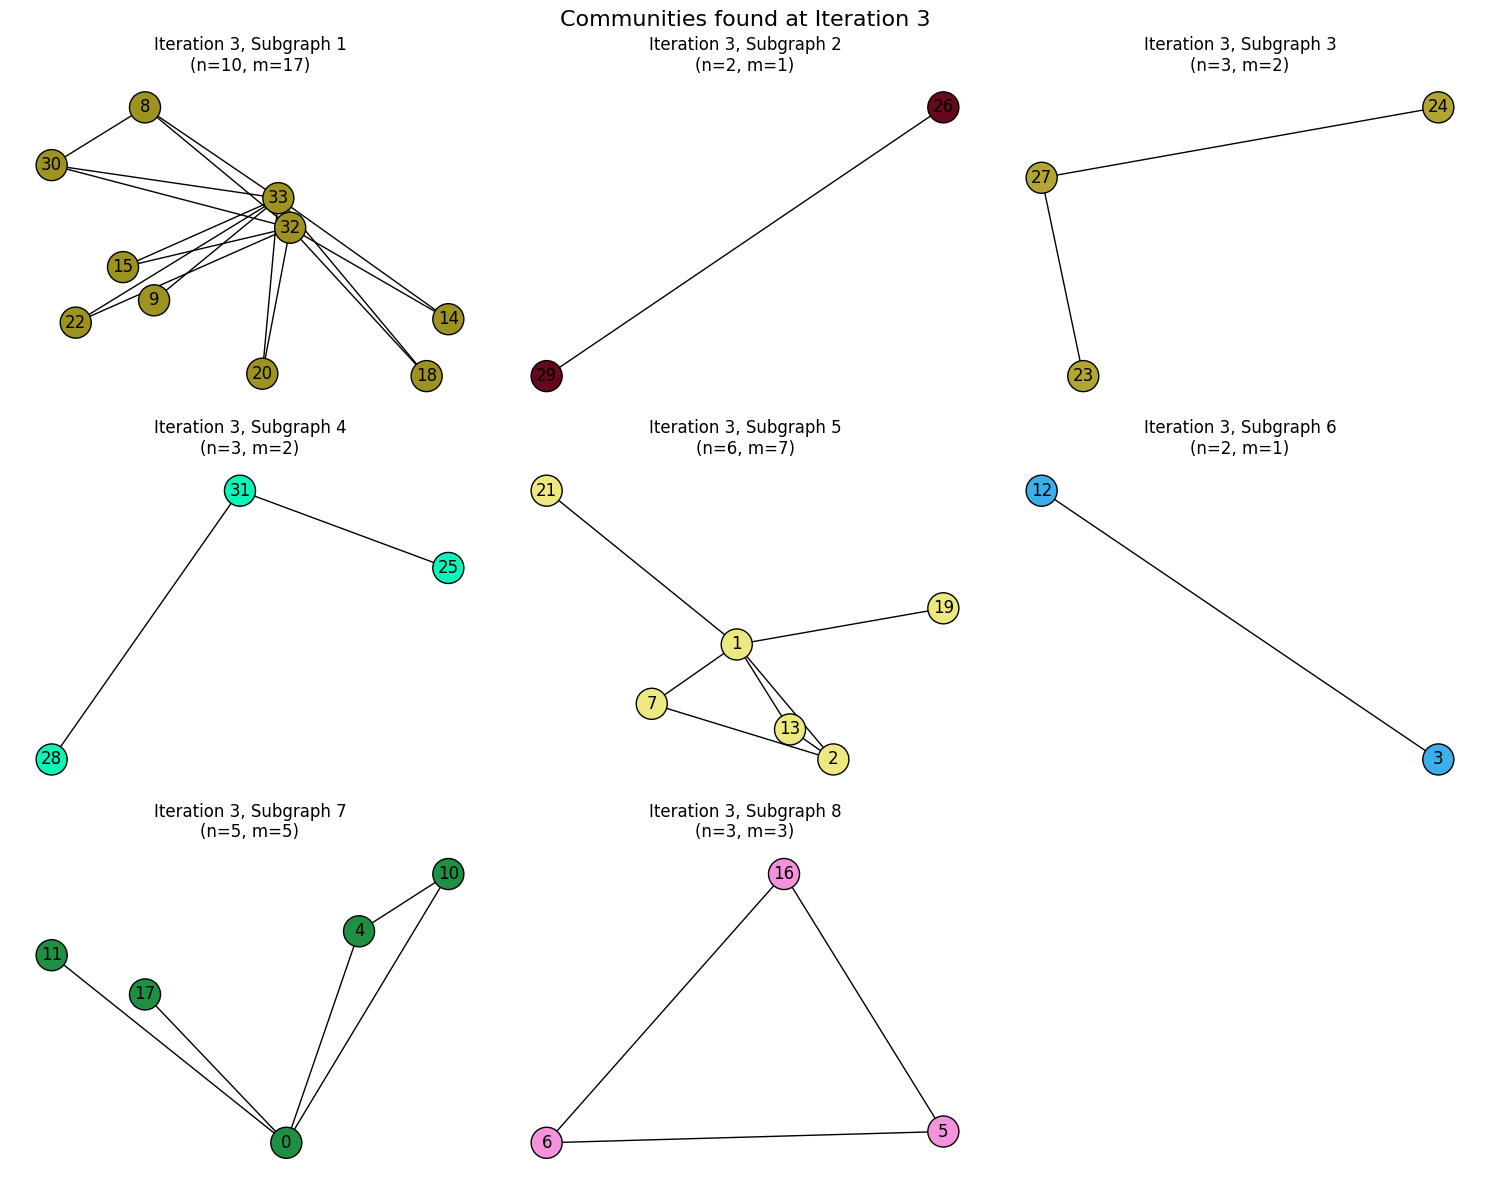

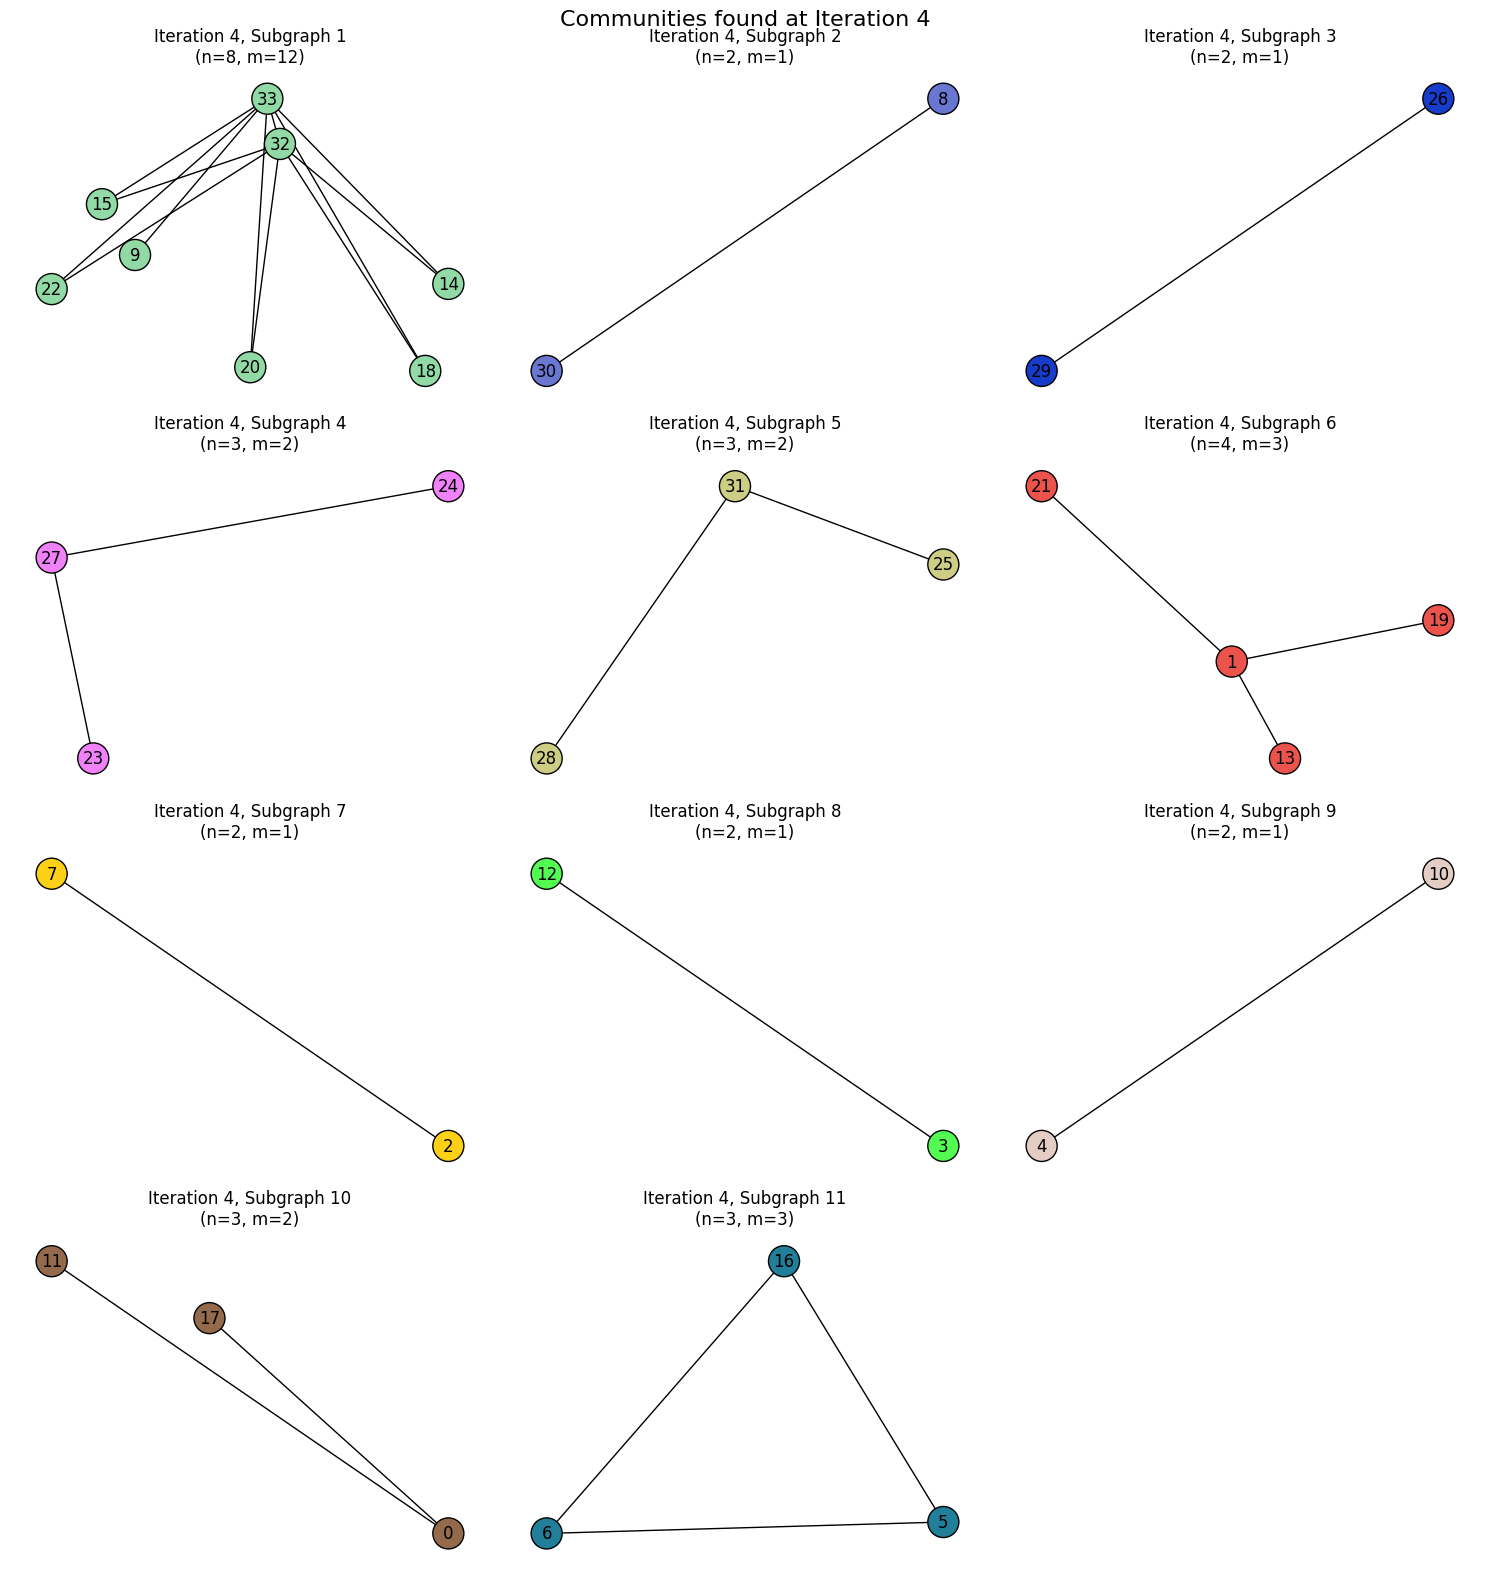

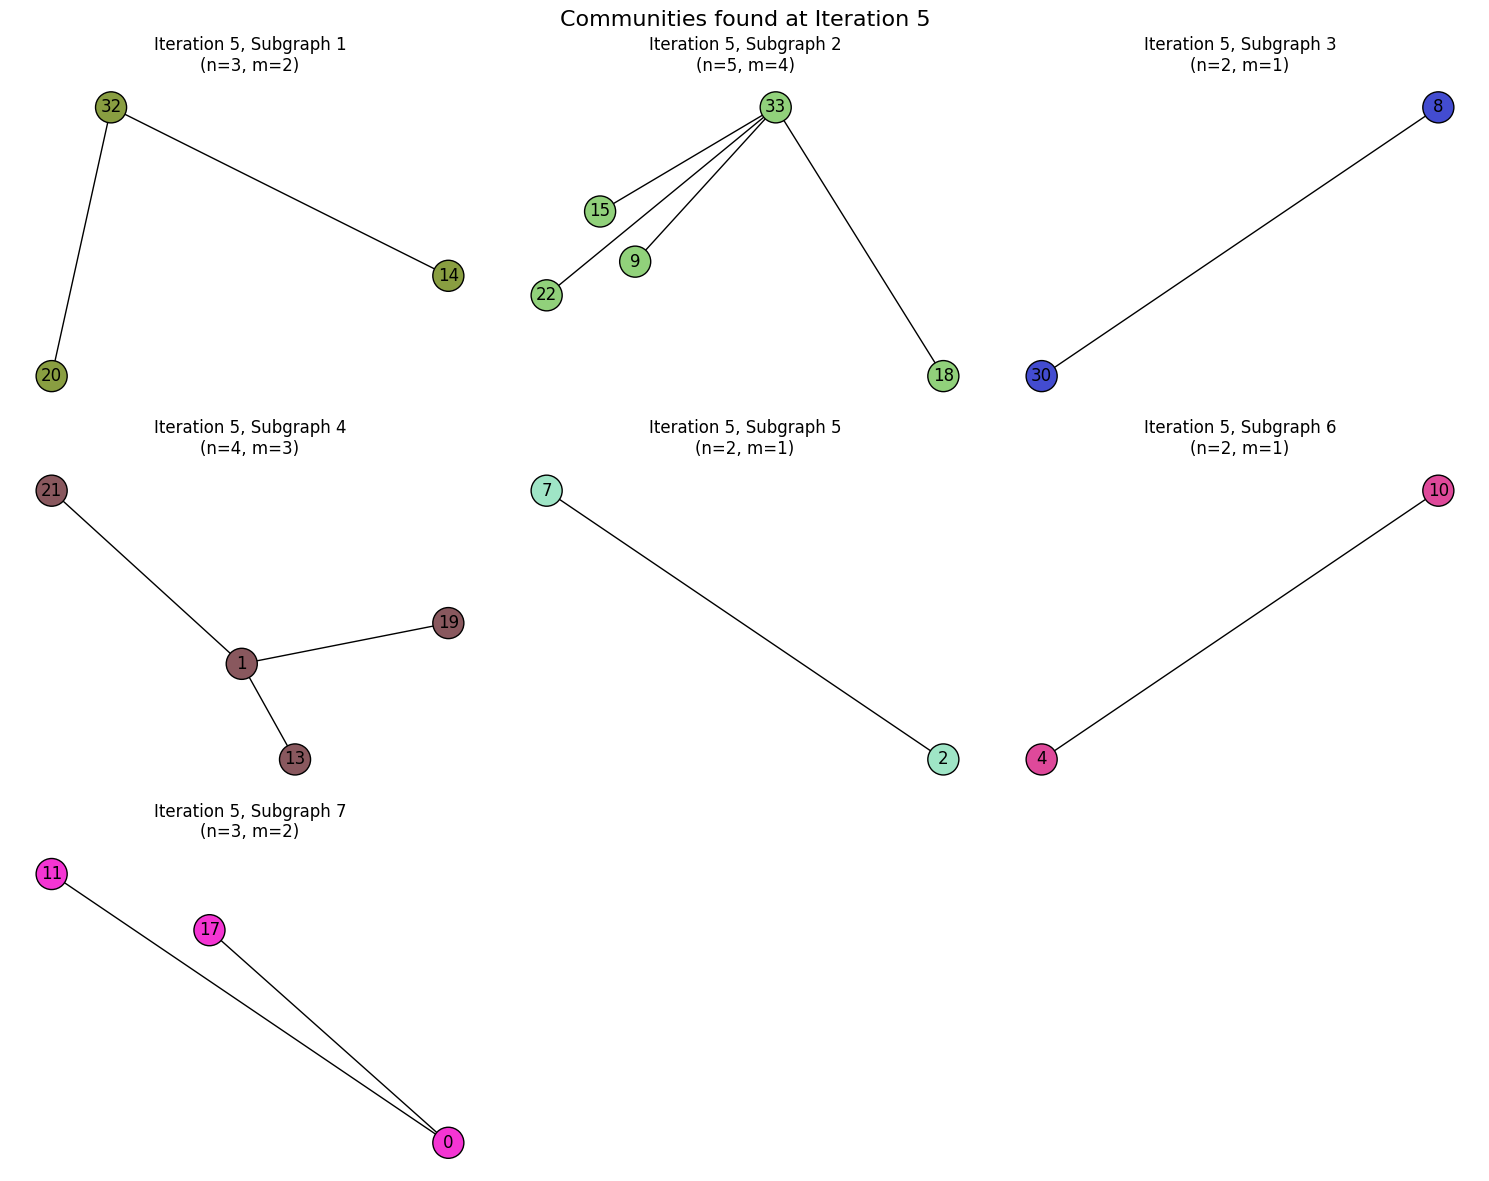

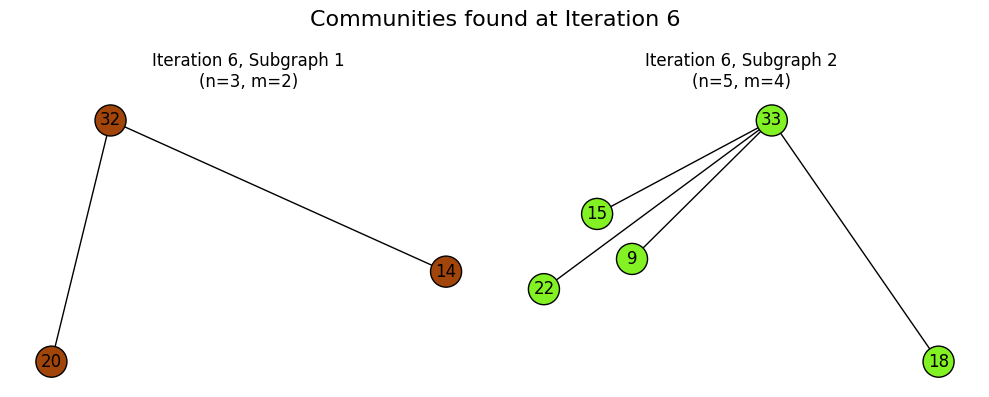

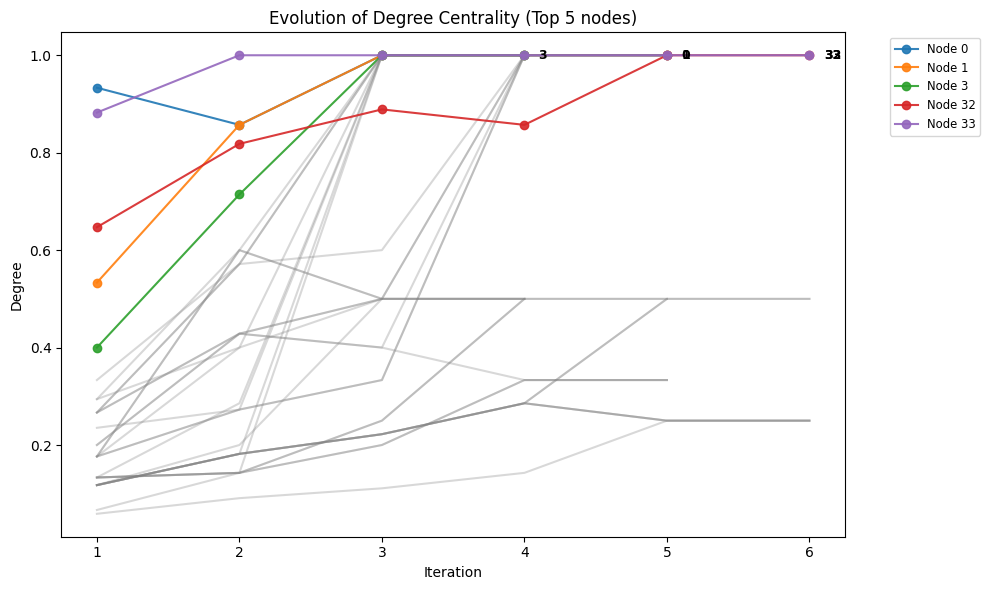

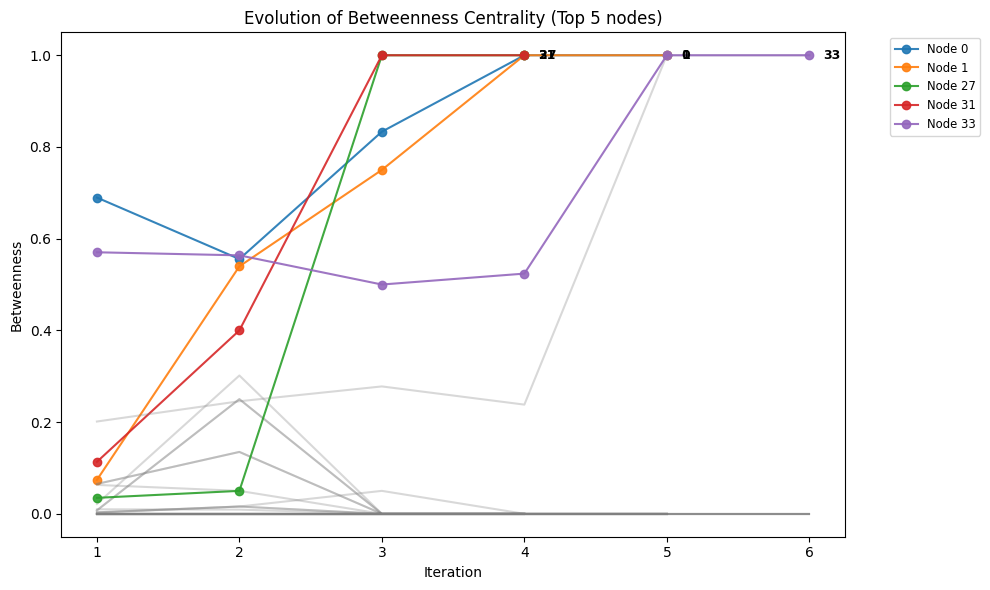

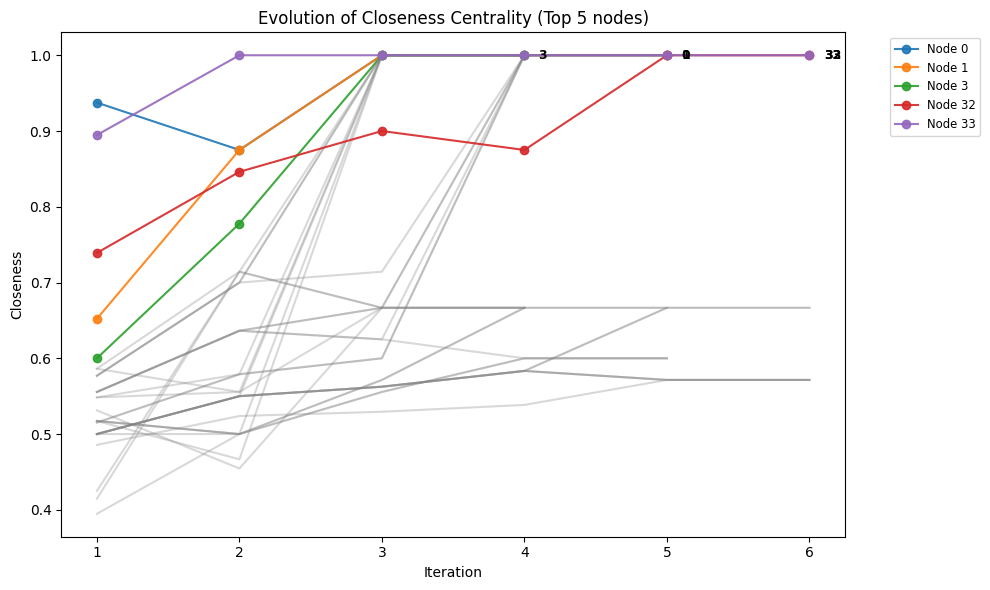

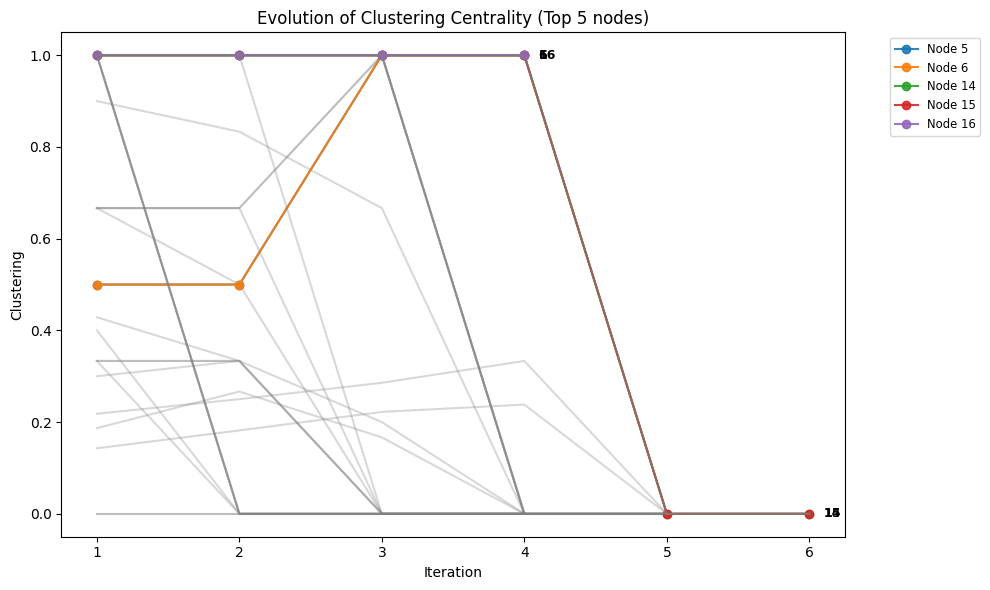

In [77]:
'''KARATE CLUB GRAPH'''

iteration = 1
community_id = 0

G = nx.karate_club_graph()
pos = nx.spring_layout(G, seed=42)

#first plot of grpha
plt.figure(figsize=(6, 5))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edgecolors='black')
plt.title("Iteration 0: Original Karate Club Graph")
plt.show()

#calling functions for splitting
groups_by_iter, global_color_map = recursive_split(G, pos, iteration)
plot_iterations(groups_by_iter, pos)
plot_metric_evolution(metric_history)


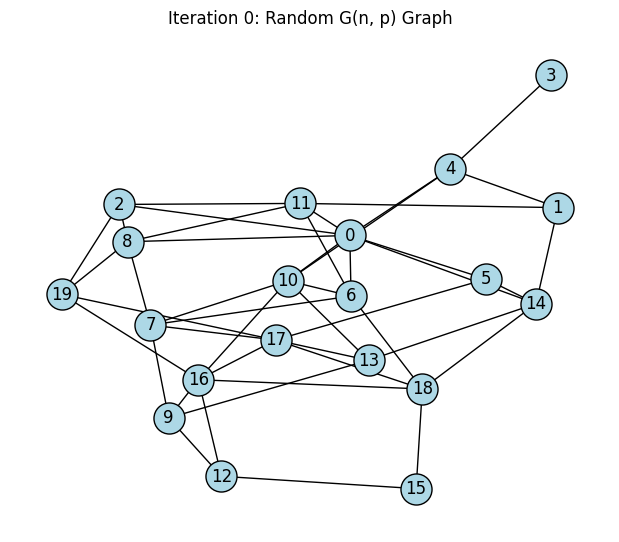

Iteration 1: λ₁ = 3.20061085, nodes = 20
Iteration 2: λ₁ = 1.67568903, nodes = 10
Iteration 3: λ₁ = 0.36019091, nodes = 5
Iteration 4: λ₁ = 0.00000000, nodes = 3
Iteration 3: λ₁ = 1.00000000, nodes = 5
Iteration 4: λ₁ = -0.00000000, nodes = 3
Iteration 2: λ₁ = 1.52776910, nodes = 10
Iteration 3: λ₁ = 0.66474696, nodes = 5
Iteration 4: λ₁ = 0.00000000, nodes = 3
Iteration 3: λ₁ = 0.00000000, nodes = 5


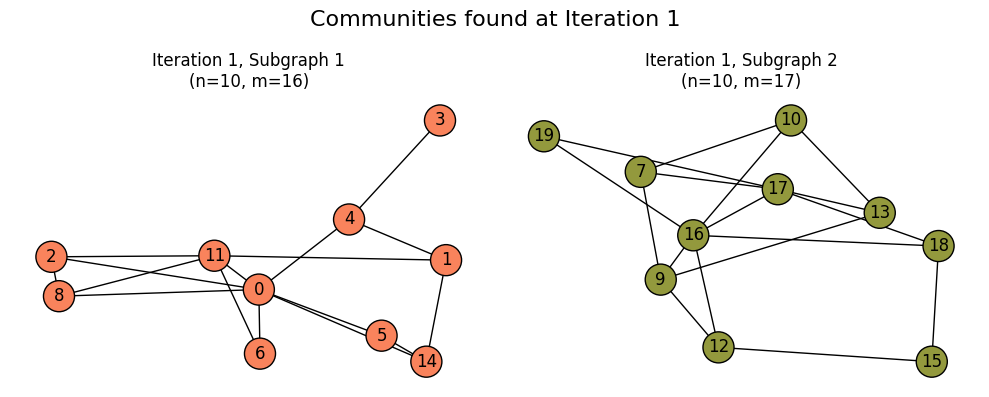

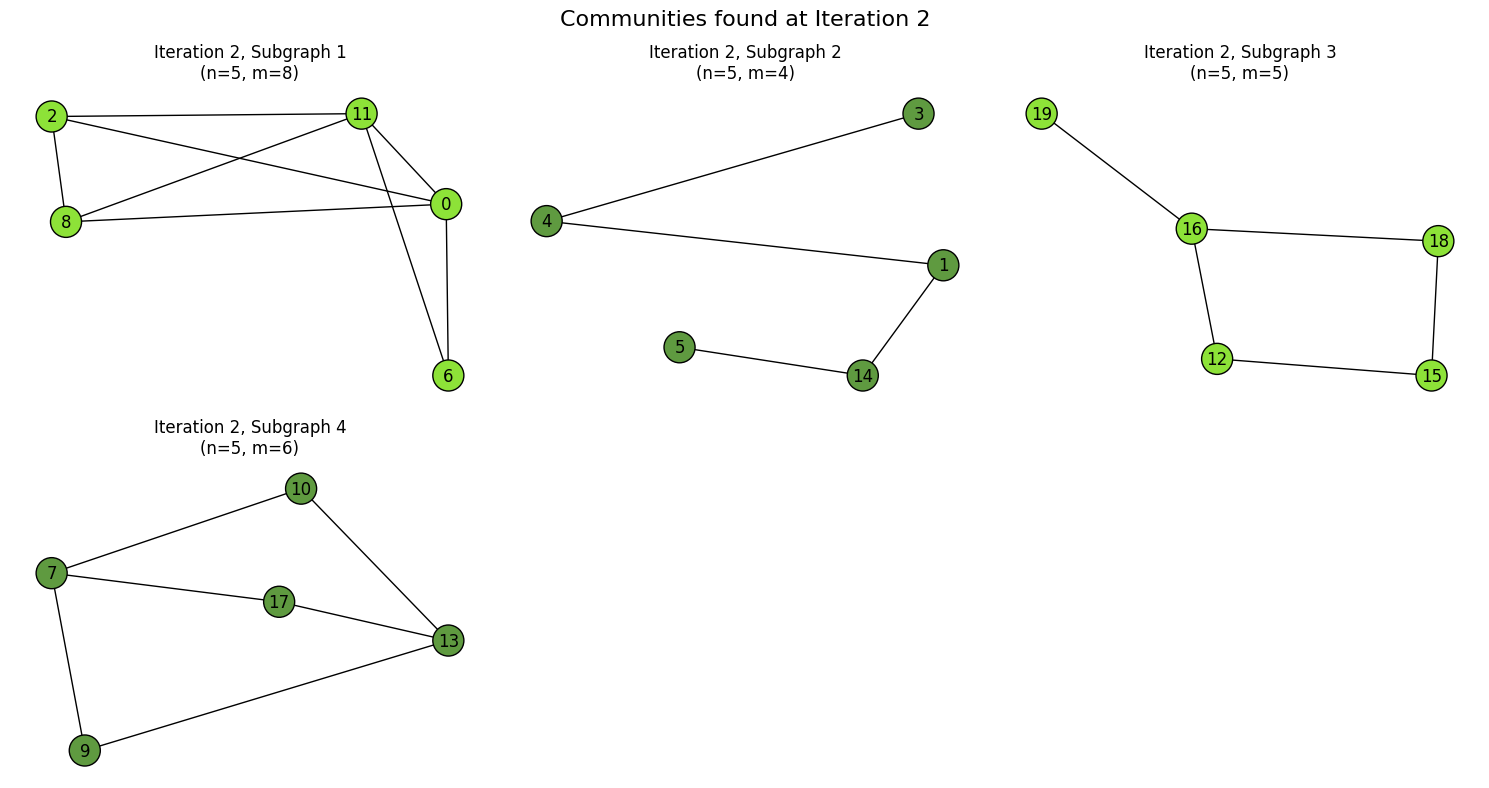

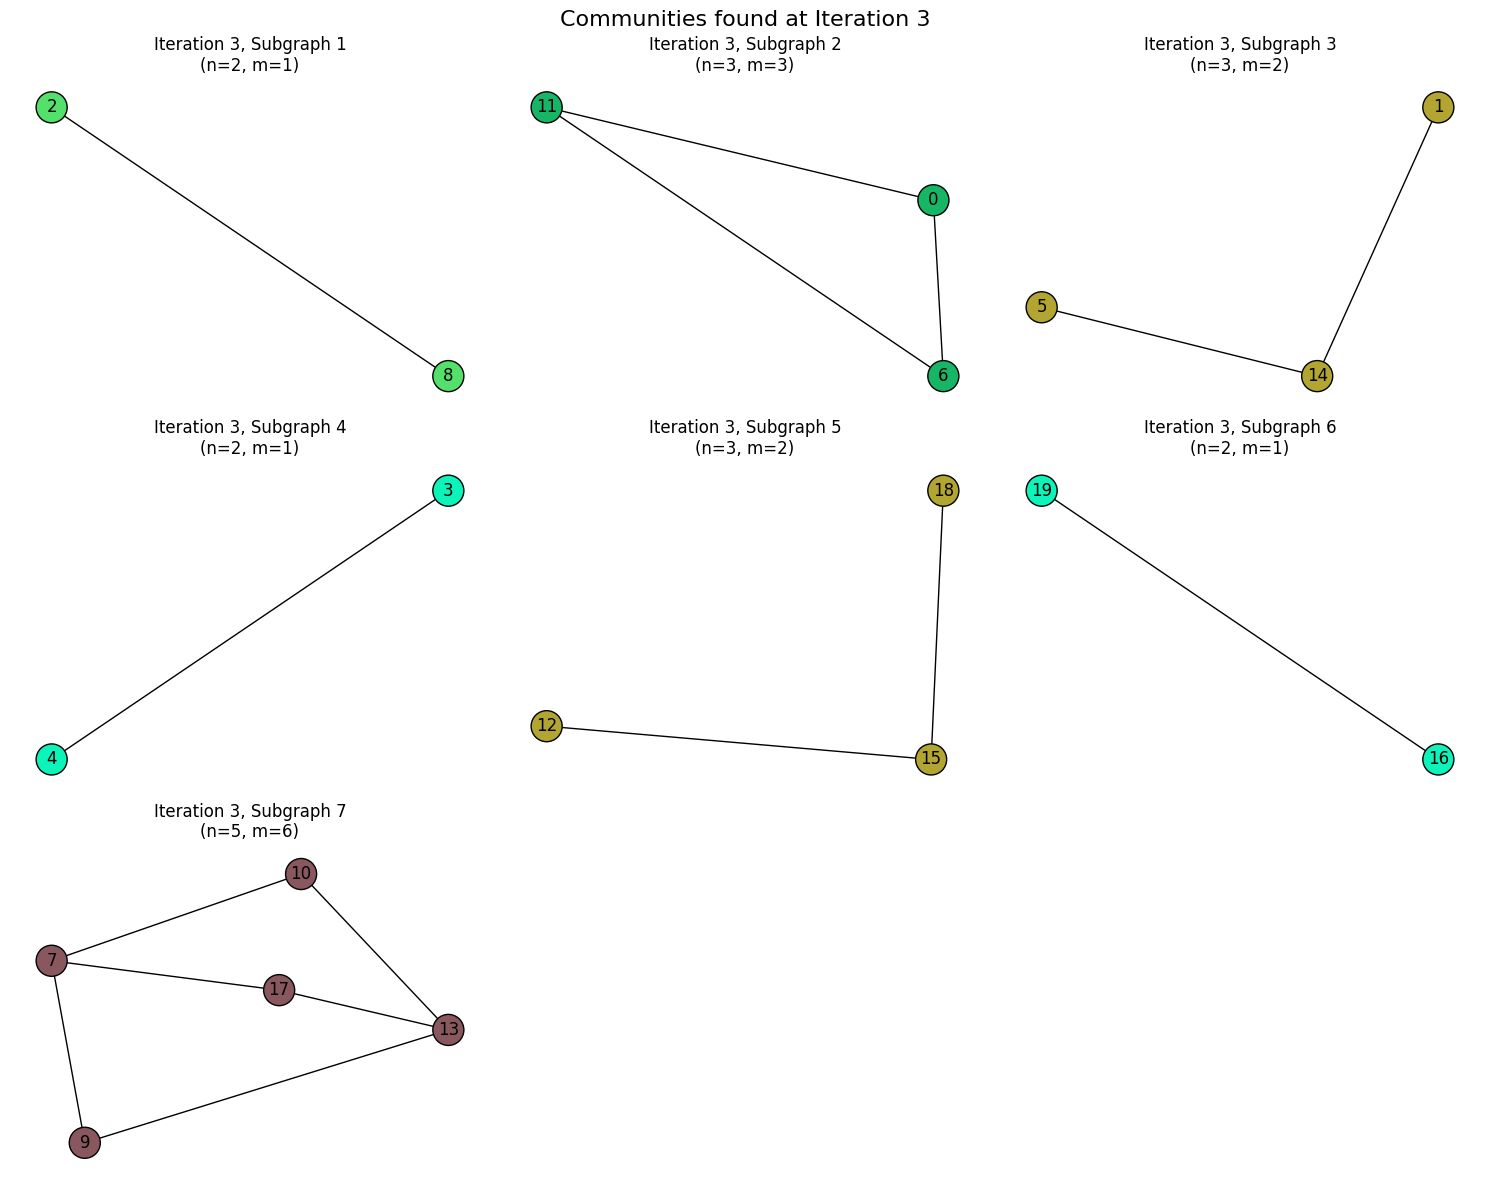

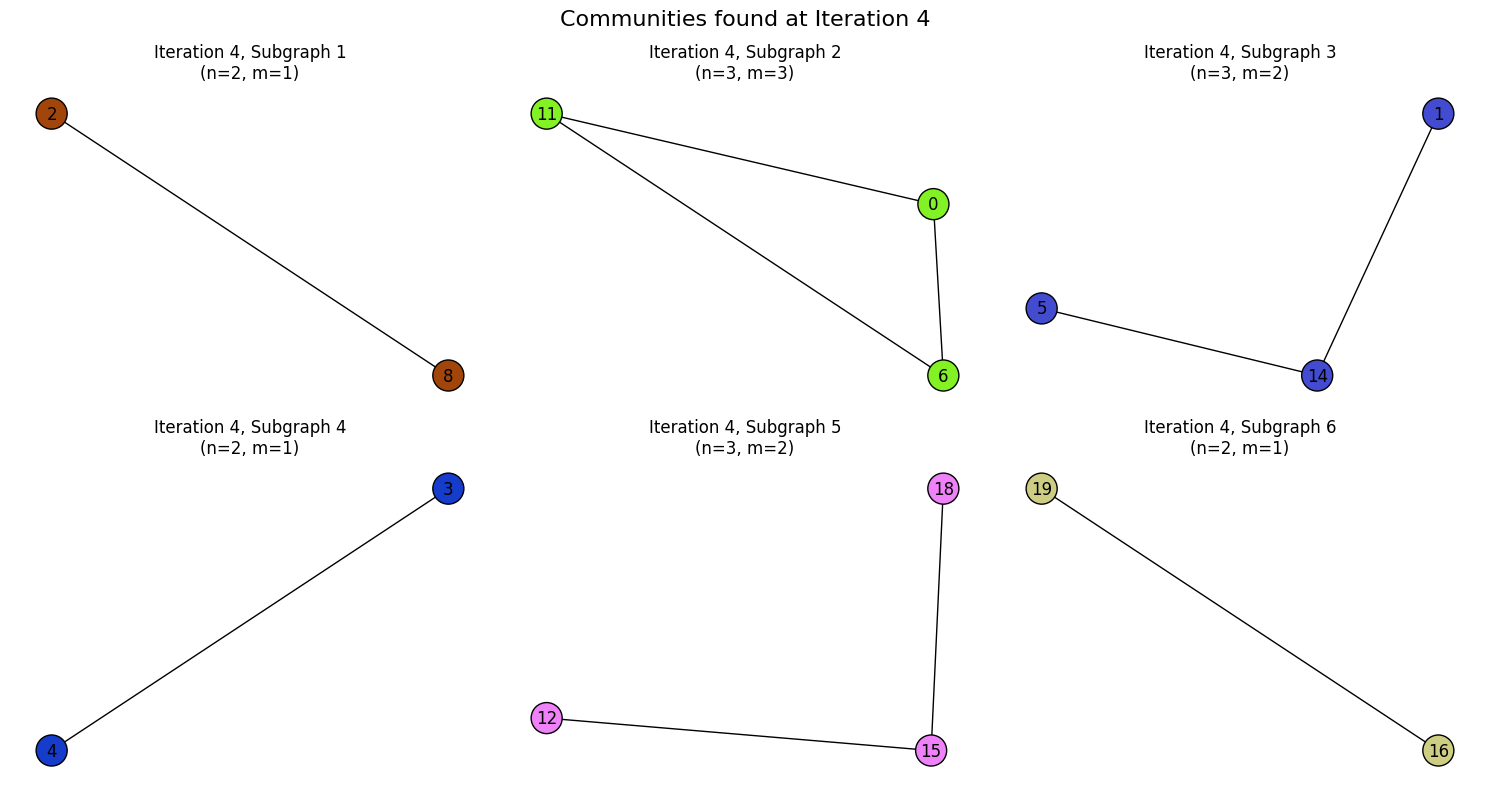

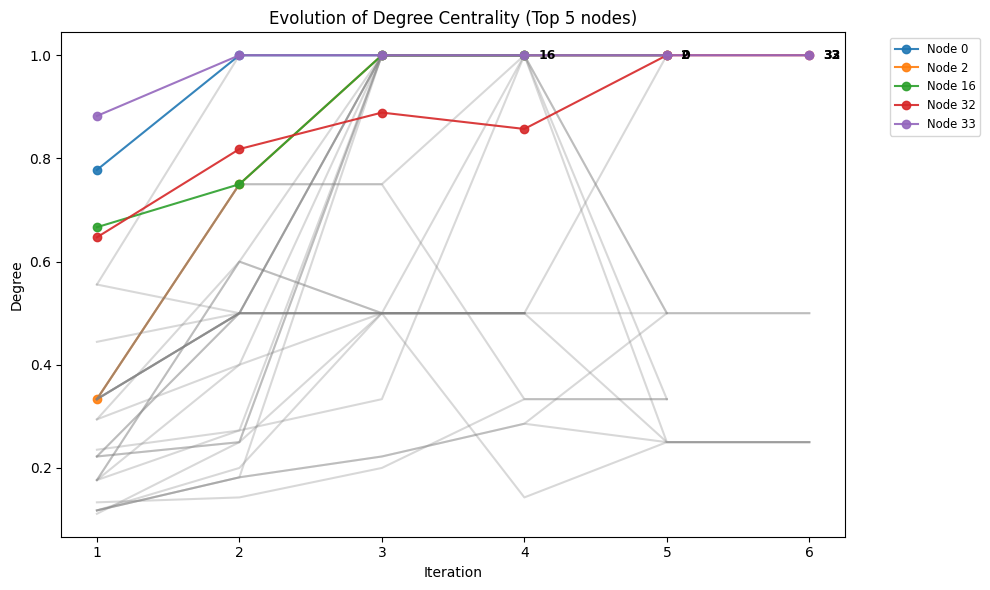

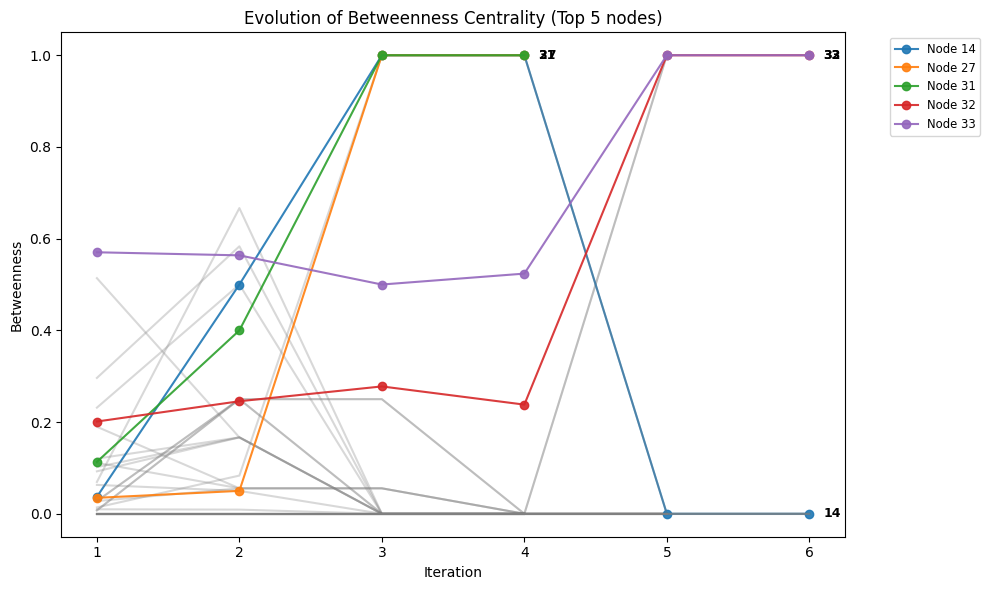

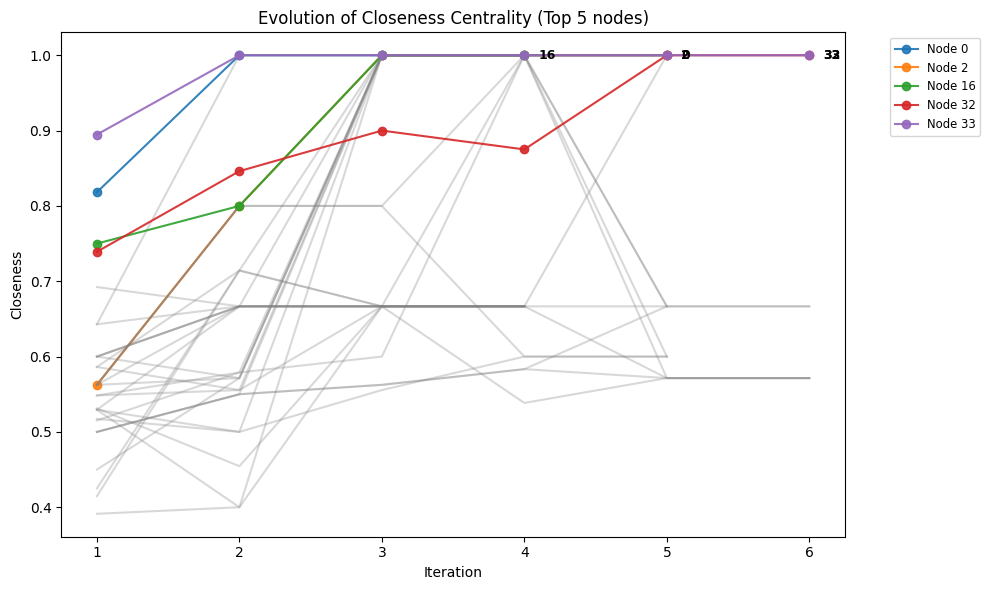

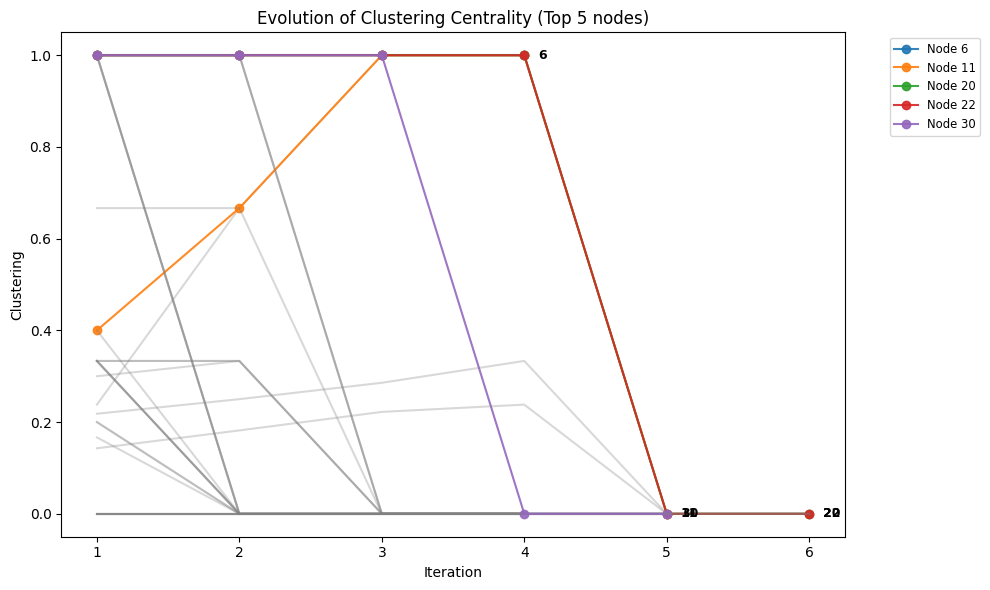

In [78]:
'''RANDOM GRAPH'''

iteration = 1
community_id = 0

#generating a random connected graph
G = nx.gnp_random_graph(n=20, p=0.2)
while not nx.is_connected(G):
    G = nx.gnp_random_graph(n=20, p=0.2, seed=np.random.randint(1000))

pos = nx.spring_layout(G, seed=42)

#first plot of grpha
plt.figure(figsize=(6, 5))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edgecolors='black')
plt.title("Iteration 0: Random G(n, p) Graph")
plt.show()

#calling functions for splitting
groups_by_iter, global_color_map = recursive_split(G, pos, iteration)
plot_iterations(groups_by_iter, pos)
plot_metric_evolution(metric_history)